In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class transformer(nn.Module):
    def __init__(self, feature_size=3, num_layers=1, dropout=0.1):  # Changed to 3 features
        super(transformer, self).__init__()
        self.model_type = "Transformer"
        self.feature_size = feature_size

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size,max_len = 5000)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout)  # nhead=1 for 3 features
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, feature_size)  # Output same number of features
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if(self.src_mask is None or self.src_mask.size(0) != len(src)):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window - output_window + 1):
        train_seq = input_data[i:i+input_window]
        train_label = input_data[i+input_window:i+input_window+output_window]
        inout_seq.append((train_seq, train_label))
    return inout_seq

def get_data(data, split, input_window, output_window):
    split_idx = int(split * len(data))
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    # Create sequences
    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_sequence = create_inout_sequences(test_data, input_window, output_window)

    return train_sequence, test_sequence

def get_batch(source, i, batch_size, input_window):
    seq_len = min(batch_size, len(source) - i)
    batch_data = source[i:i+seq_len]
    
    input_batch = torch.stack([torch.FloatTensor(item[0]) for item in batch_data])
    target_batch = torch.stack([torch.FloatTensor(item[1]) for item in batch_data])
    
    # Reshape for transformer: (seq_len, batch_size, features)
    input_batch = input_batch.transpose(0, 1)
    target_batch = target_batch.transpose(0, 1)
    
    return input_batch, target_batch

def train(model, train_data, optimizer, criterion, input_window, batch_size, epoch, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size, input_window)
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        # Use only the last output_window predictions
        loss = criterion(output[-4:], targets)  # Last 4 predictions
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        
        if batch_idx % 10 == 0 and batch_idx > 0:
            cur_loss = total_loss / (batch_idx + 1)
            elapsed = time.time() - start_time
            print(f"Epoch {epoch} | Batch {batch_idx}/{len(train_data)//batch_size} | Loss: {cur_loss:.6f} | Time: {elapsed:.2f}s")

    return total_loss / (len(train_data) // batch_size)

def evaluate(model, data_source, criterion, input_window, device):
    model.eval()
    total_loss = 0.0
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
            data, targets = get_batch(data_source, i, batch_size, input_window)
            data, targets = data.to(device), targets.to(device)
            
            output = model(data)
            loss = criterion(output[-4:], targets)  # Last 4 predictions
            total_loss += loss.item()

    return total_loss / (len(data_source) // batch_size)

# Generate synthetic data: 1000 rows, 3 columns
np.random.seed(42)
data = np.random.randn(1000, 3)
# Add some trend and correlation
for i in range(1, 1000):
    data[i] = 0.9 * data[i-1] + 0.1 * np.random.randn(3)

# Convert to DataFrame
df = pd.DataFrame(data, columns=['feature1', 'feature2', 'feature3'])

# Parameters
input_window = 10
output_window = 4  # Changed to 4
batch_size = 32
feature_size = 3
epochs = 50

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Prepare data
train_data, val_data = get_data(data, 0.8, input_window, output_window)
print(f"Train sequences: {len(train_data)}, Validation sequences: {len(val_data)}")

# Model
model = transformer(feature_size=feature_size, num_layers=2, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Training loop with loss tracking
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    
    # Train
    train_loss = train(model, train_data, optimizer, criterion, input_window, batch_size, epoch, device)
    
    # Validate
    val_loss = evaluate(model, val_data, criterion, input_window, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    elapsed = time.time() - epoch_start_time
    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {elapsed:.2f}s")
    print("-" * 80)
    
    scheduler.step()

# Plot loss evolution
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Make a sample prediction
model.eval()
with torch.no_grad():
    sample_input = torch.FloatTensor(train_data[0][0]).unsqueeze(1).to(device)  # (seq_len, 1, features)
    prediction = model(sample_input)
    
    print(f"\nSample Input Shape: {sample_input.shape}")
    print(f"Sample Prediction Shape: {prediction.shape}")
    print(f"Last 4 predictions (output_window={output_window}):")
    print(prediction[-4:].cpu().numpy())

print(f"\nModel Summary:")
print(f"- Input Window: {input_window}")
print(f"- Output Window: {output_window}")
print(f"- Features: {feature_size}")
print(f"- Data Shape: {data.shape}")
print(f"- Final Train Loss: {train_losses[-1]:.6f}")
print(f"- Final Val Loss: {val_losses[-1]:.6f}")

Device: cuda
Train sequences: 787, Validation sequences: 187


RuntimeError: The expanded size of the tensor (1) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [5000, 1].  Tensor sizes: [5000, 2]

Device: cuda
Train sequences: 787, Validation sequences: 187
Starting training...
Epoch 1 | Batch 10/24 | Loss: 0.059016 | Time: 0.07s
Epoch 1 | Batch 20/24 | Loss: 0.051393 | Time: 0.11s
Epoch 1/50 | Train Loss: 0.051498 | Val Loss: 0.078140 | Time: 0.13s
--------------------------------------------------------------------------------
Epoch 2 | Batch 10/24 | Loss: 0.054954 | Time: 0.04s


/home/mechaquanta/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2 | Batch 20/24 | Loss: 0.049010 | Time: 0.07s
Epoch 2/50 | Train Loss: 0.049263 | Val Loss: 0.076730 | Time: 0.09s
--------------------------------------------------------------------------------
Epoch 3 | Batch 10/24 | Loss: 0.054047 | Time: 0.04s
Epoch 3 | Batch 20/24 | Loss: 0.048621 | Time: 0.07s
Epoch 3/50 | Train Loss: 0.048875 | Val Loss: 0.076620 | Time: 0.09s
--------------------------------------------------------------------------------
Epoch 4 | Batch 10/24 | Loss: 0.053610 | Time: 0.04s
Epoch 4 | Batch 20/24 | Loss: 0.048282 | Time: 0.07s
Epoch 4/50 | Train Loss: 0.048543 | Val Loss: 0.075624 | Time: 0.09s
--------------------------------------------------------------------------------
Epoch 5 | Batch 10/24 | Loss: 0.053309 | Time: 0.04s
Epoch 5 | Batch 20/24 | Loss: 0.048106 | Time: 0.07s
Epoch 5/50 | Train Loss: 0.048368 | Val Loss: 0.075955 | Time: 0.09s
--------------------------------------------------------------------------------
Epoch 6 | Batch 10/24 | Loss:

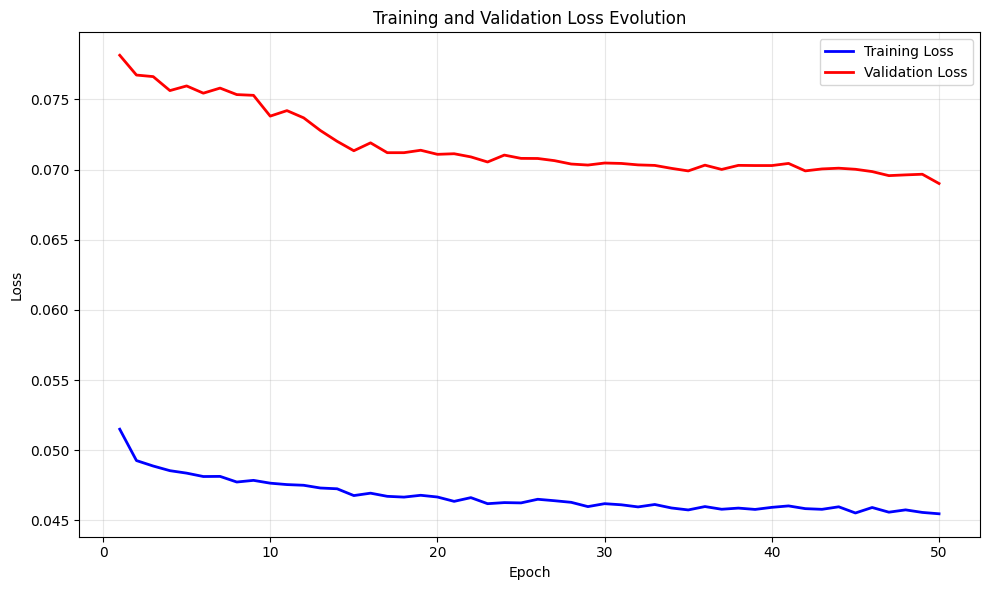


Sample Input Shape: torch.Size([10, 1, 3])
Sample Prediction Shape: torch.Size([10, 1, 3])
Last 4 predictions (output_window=4):
[[[-0.06744807 -0.07850525  0.00985661]]

 [[-0.01749838 -0.1065606  -0.03279845]]

 [[-0.04387777 -0.09351449 -0.0114607 ]]

 [[-0.07917053 -0.06968778  0.02136722]]]

Model Summary:
- Input Window: 10
- Output Window: 4
- Features: 3
- Data Shape: (1000, 3)
- Final Train Loss: 0.045471
- Final Val Loss: 0.069002


In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Handle odd d_model by ensuring we don't go out of bounds
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model > 1:
            pe[:, 1::2] = torch.cos(position * div_term[:d_model//2])
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class transformer(nn.Module):
    def __init__(self, feature_size=3, num_layers=1, dropout=0.1):  # Changed to 3 features
        super(transformer, self).__init__()
        self.model_type = "Transformer"
        self.feature_size = feature_size

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout)  # nhead=1 for 3 features
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, feature_size)  # Output same number of features
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if(self.src_mask is None or self.src_mask.size(0) != len(src)):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window - output_window + 1):
        train_seq = input_data[i:i+input_window]
        train_label = input_data[i+input_window:i+input_window+output_window]
        inout_seq.append((train_seq, train_label))
    return inout_seq

def get_data(data, split, input_window, output_window):
    split_idx = int(split * len(data))
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    # Create sequences
    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_sequence = create_inout_sequences(test_data, input_window, output_window)

    return train_sequence, test_sequence

def get_batch(source, i, batch_size, input_window):
    seq_len = min(batch_size, len(source) - i)
    batch_data = source[i:i+seq_len]
    
    input_batch = torch.stack([torch.FloatTensor(item[0]) for item in batch_data])
    target_batch = torch.stack([torch.FloatTensor(item[1]) for item in batch_data])
    
    # Reshape for transformer: (seq_len, batch_size, features)
    input_batch = input_batch.transpose(0, 1)
    target_batch = target_batch.transpose(0, 1)
    
    return input_batch, target_batch

def train(model, train_data, optimizer, criterion, input_window, batch_size, epoch, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size, input_window)
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        # Use only the last output_window predictions
        loss = criterion(output[-4:], targets)  # Last 4 predictions
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        
        if batch_idx % 10 == 0 and batch_idx > 0:
            cur_loss = total_loss / (batch_idx + 1)
            elapsed = time.time() - start_time
            print(f"Epoch {epoch} | Batch {batch_idx}/{len(train_data)//batch_size} | Loss: {cur_loss:.6f} | Time: {elapsed:.2f}s")

    return total_loss / (len(train_data) // batch_size)

def evaluate(model, data_source, criterion, input_window, device):
    model.eval()
    total_loss = 0.0
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
            data, targets = get_batch(data_source, i, batch_size, input_window)
            data, targets = data.to(device), targets.to(device)
            
            output = model(data)
            loss = criterion(output[-4:], targets)  # Last 4 predictions
            total_loss += loss.item()

    return total_loss / (len(data_source) // batch_size)

# Generate synthetic data: 1000 rows, 3 columns
np.random.seed(42)
data = np.random.randn(1000, 3)
# Add some trend and correlation
for i in range(1, 1000):
    data[i] = 0.9 * data[i-1] + 0.1 * np.random.randn(3)

# Convert to DataFrame
df = pd.DataFrame(data, columns=['feature1', 'feature2', 'feature3'])

# Parameters
input_window = 10
output_window = 4  # Changed to 4
batch_size = 32
feature_size = 3
epochs = 50

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Prepare data
train_data, val_data = get_data(data, 0.8, input_window, output_window)
print(f"Train sequences: {len(train_data)}, Validation sequences: {len(val_data)}")

# Model
model = transformer(feature_size=feature_size, num_layers=2, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Training loop with loss tracking
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    
    # Train
    train_loss = train(model, train_data, optimizer, criterion, input_window, batch_size, epoch, device)
    
    # Validate
    val_loss = evaluate(model, val_data, criterion, input_window, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    elapsed = time.time() - epoch_start_time
    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {elapsed:.2f}s")
    print("-" * 80)
    
    scheduler.step()

# Plot loss evolution
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("sajid.png")
plt.show()

# Make a sample prediction
model.eval()
with torch.no_grad():
    sample_input = torch.FloatTensor(train_data[0][0]).unsqueeze(1).to(device)  # (seq_len, 1, features)
    prediction = model(sample_input)
    
    print(f"\nSample Input Shape: {sample_input.shape}")
    print(f"Sample Prediction Shape: {prediction.shape}")
    print(f"Last 4 predictions (output_window={output_window}):")
    print(prediction[-4:].cpu().numpy())

print(f"\nModel Summary:")
print(f"- Input Window: {input_window}")
print(f"- Output Window: {output_window}")
print(f"- Features: {feature_size}")
print(f"- Data Shape: {data.shape}")
print(f"- Final Train Loss: {train_losses[-1]:.6f}")
print(f"- Final Val Loss: {val_losses[-1]:.6f}")

Device: cuda
Train sequences: 787, Validation sequences: 187
Starting training...
Epoch 1 | Batch 10/24 | Loss: 1701.301319 | Time: 0.05s
Epoch 1 | Batch 20/24 | Loss: 5944.455383 | Time: 0.09s
Epoch 1/50 | Train Loss: 8694.104677 | Val Loss: 37266.478906 | Time: 0.11s
--------------------------------------------------------------------------------
Epoch 2 | Batch 10/24 | Loss: 1696.821617 | Time: 0.04s
Epoch 2 | Batch 20/24 | Loss: 5936.077157 | Time: 0.07s


/home/mechaquanta/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2/50 | Train Loss: 8683.672819 | Val Loss: 37239.266797 | Time: 0.11s
--------------------------------------------------------------------------------
Epoch 3 | Batch 10/24 | Loss: 1691.997226 | Time: 0.04s
Epoch 3 | Batch 20/24 | Loss: 5926.893078 | Time: 0.07s
Epoch 3/50 | Train Loss: 8672.242218 | Val Loss: 37209.315234 | Time: 0.09s
--------------------------------------------------------------------------------
Epoch 4 | Batch 10/24 | Loss: 1686.720851 | Time: 0.04s
Epoch 4 | Batch 20/24 | Loss: 5916.867242 | Time: 0.08s
Epoch 4/50 | Train Loss: 8659.763719 | Val Loss: 37176.671484 | Time: 0.11s
--------------------------------------------------------------------------------
Epoch 5 | Batch 10/24 | Loss: 1680.972942 | Time: 0.05s
Epoch 5 | Batch 20/24 | Loss: 5905.956274 | Time: 0.09s
Epoch 5/50 | Train Loss: 8646.199045 | Val Loss: 37141.209375 | Time: 0.11s
--------------------------------------------------------------------------------
Epoch 6 | Batch 10/24 | Loss: 1674.7

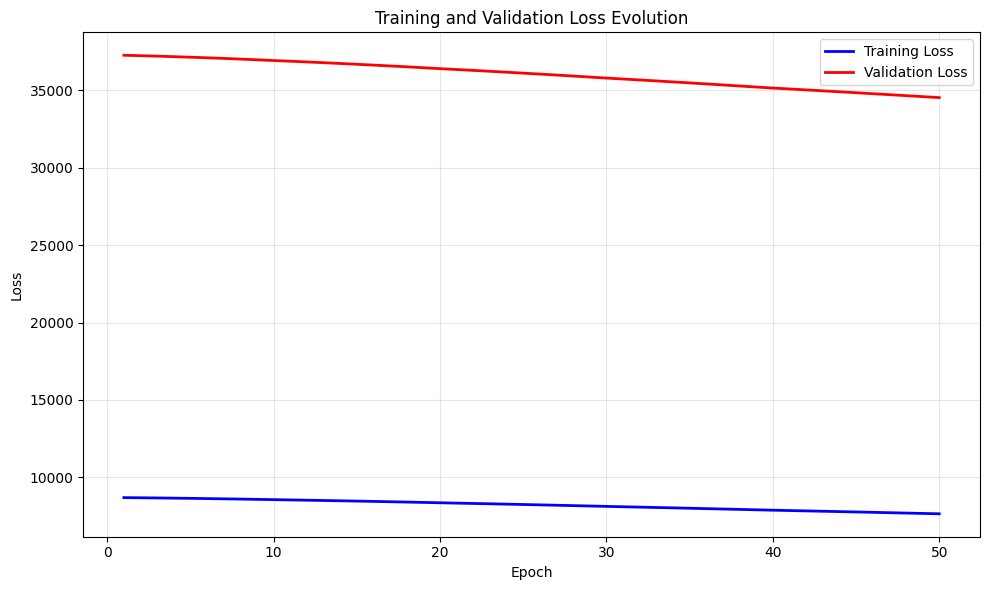


Sample Input Shape: torch.Size([10, 1, 3])
Sample Prediction Shape: torch.Size([10, 1, 3])
Last 4 predictions (output_window=4):
[[[ 5.3604965   0.526926    0.06538036]]

 [[ 5.439735    0.5341667   0.06642121]]

 [[ 6.2790093   0.61076367  0.07701747]]

 [[11.682344    1.0944147   0.10217988]]]

Model Summary:
- Input Window: 10
- Output Window: 4
- Features: 3
- Data Shape: (1000, 3)
- Final Train Loss: 7649.405691
- Final Val Loss: 34530.894922


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Handle odd d_model by ensuring we don't go out of bounds
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model > 1:
            pe[:, 1::2] = torch.cos(position * div_term[:d_model//2])
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class transformer(nn.Module):
    def __init__(self, feature_size=3, num_layers=1, dropout=0.1):  # Changed to 3 features
        super(transformer, self).__init__()
        self.model_type = "Transformer"
        self.feature_size = feature_size

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout)  # nhead=1 for 3 features
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, feature_size)  # Output same number of features
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if(self.src_mask is None or self.src_mask.size(0) != len(src)):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window - output_window + 1):
        train_seq = input_data[i:i+input_window]
        train_label = input_data[i+input_window:i+input_window+output_window]
        inout_seq.append((train_seq, train_label))
    return inout_seq

def get_data(data, split, input_window, output_window):
    split_idx = int(split * len(data))
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    # Create sequences
    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_sequence = create_inout_sequences(test_data, input_window, output_window)

    return train_sequence, test_sequence

def get_batch(source, i, batch_size, input_window):
    seq_len = min(batch_size, len(source) - i)
    batch_data = source[i:i+seq_len]
    
    input_batch = torch.stack([torch.FloatTensor(item[0]) for item in batch_data])
    target_batch = torch.stack([torch.FloatTensor(item[1]) for item in batch_data])
    
    # Reshape for transformer: (seq_len, batch_size, features)
    input_batch = input_batch.transpose(0, 1)
    target_batch = target_batch.transpose(0, 1)
    
    return input_batch, target_batch

def train(model, train_data, optimizer, criterion, input_window, batch_size, epoch, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size, input_window)
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        # Use only the last output_window predictions
        loss = criterion(output[-4:], targets)  # Last 4 predictions
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        
        if batch_idx % 10 == 0 and batch_idx > 0:
            cur_loss = total_loss / (batch_idx + 1)
            elapsed = time.time() - start_time
            print(f"Epoch {epoch} | Batch {batch_idx}/{len(train_data)//batch_size} | Loss: {cur_loss:.6f} | Time: {elapsed:.2f}s")

    return total_loss / (len(train_data) // batch_size)

def evaluate(model, data_source, criterion, input_window, device):
    model.eval()
    total_loss = 0.0
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
            data, targets = get_batch(data_source, i, batch_size, input_window)
            data, targets = data.to(device), targets.to(device)
            
            output = model(data)
            loss = criterion(output[-4:], targets)  # Last 4 predictions
            total_loss += loss.item()

    return total_loss / (len(data_source) // batch_size)

# Read Excel data
df = pd.read_excel('interpolated_keff_1000_rows.xlsx')  # Replace 'your_file.xlsx' with your actual file path

# If you need to select specific columns, uncomment and modify:
df = df[['Time [days]', 'keff_1', 'Unnamed: 3']]  # Replace with your actual column names

# If you need to limit to 1000 rows:
df = df.head(1000)

# Convert to numpy array for processing
data = df.values

# Parameters
input_window = 10
output_window = 4  # Changed to 4
batch_size = 32
feature_size = 3
epochs = 50

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Prepare data
train_data, val_data = get_data(data, 0.8, input_window, output_window)
print(f"Train sequences: {len(train_data)}, Validation sequences: {len(val_data)}")

# Model
model = transformer(feature_size=feature_size, num_layers=2, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Training loop with loss tracking
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    
    # Train
    train_loss = train(model, train_data, optimizer, criterion, input_window, batch_size, epoch, device)
    
    # Validate
    val_loss = evaluate(model, val_data, criterion, input_window, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    elapsed = time.time() - epoch_start_time
    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {elapsed:.2f}s")
    print("-" * 80)
    
    scheduler.step()

# Plot loss evolution
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("loss.png")
plt.show()

# Make a sample prediction
model.eval()
with torch.no_grad():
    sample_input = torch.FloatTensor(train_data[0][0]).unsqueeze(1).to(device)  # (seq_len, 1, features)
    prediction = model(sample_input)
    
    print(f"\nSample Input Shape: {sample_input.shape}")
    print(f"Sample Prediction Shape: {prediction.shape}")
    print(f"Last 4 predictions (output_window={output_window}):")
    print(prediction[-4:].cpu().numpy())

print(f"\nModel Summary:")
print(f"- Input Window: {input_window}")
print(f"- Output Window: {output_window}")
print(f"- Features: {feature_size}")
print(f"- Data Shape: {data.shape}")
print(f"- Final Train Loss: {train_losses[-1]:.6f}")
print(f"- Final Val Loss: {val_losses[-1]:.6f}")

Loading data...
Data shape: (1000, 3)
Data range - Min: 0.0000, Max: 336.0000
Normalized data range - Min: -11.0968, Max: 31.6070
Creating sequences...
Sequences shape: X=(987, 10, 3), y=(987, 4, 3)
Train: (789, 10, 3), Val: (198, 10, 3)
Device: cuda
Starting training...
Epoch  1/50 | Train: 0.042082 | Val: 1.198966 | Time: 0.20s | LR: 0.0005000
Epoch  2/50 | Train: 0.012853 | Val: 1.188884 | Time: 0.20s | LR: 0.0005000
Epoch  3/50 | Train: 0.010032 | Val: 1.189126 | Time: 0.17s | LR: 0.0005000
Epoch  4/50 | Train: 0.007907 | Val: 1.190970 | Time: 0.19s | LR: 0.0005000
Epoch  5/50 | Train: 0.006602 | Val: 1.186720 | Time: 0.22s | LR: 0.0005000
Epoch  6/50 | Train: 0.005444 | Val: 1.182548 | Time: 0.18s | LR: 0.0005000
Epoch  7/50 | Train: 0.004827 | Val: 1.180394 | Time: 0.20s | LR: 0.0005000
Epoch  8/50 | Train: 0.004124 | Val: 1.183145 | Time: 0.22s | LR: 0.0005000
Epoch  9/50 | Train: 0.003632 | Val: 1.179836 | Time: 0.18s | LR: 0.0005000
Epoch 10/50 | Train: 0.003377 | Val: 1.18092

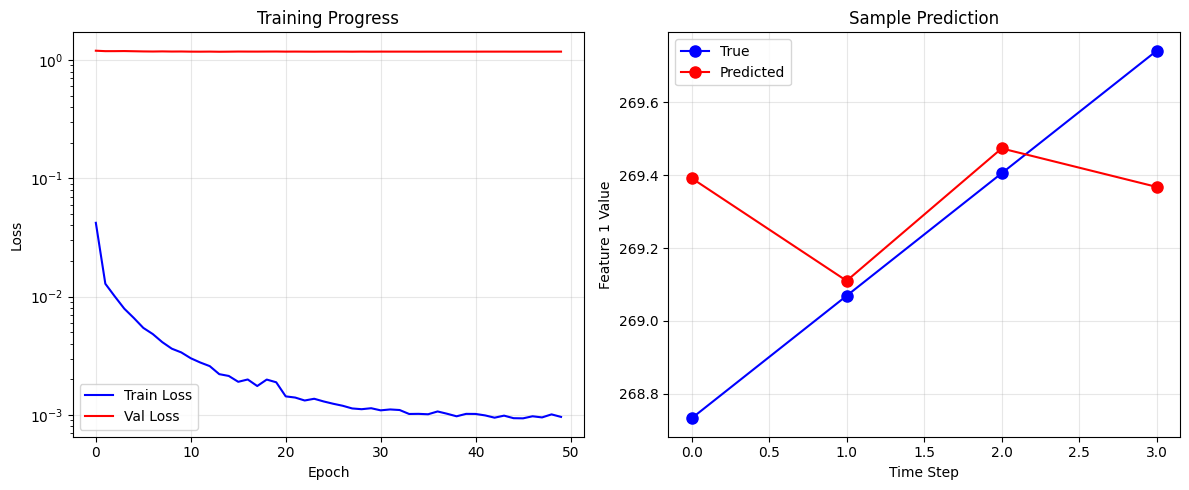


FINAL RESULTS:
Best Validation Loss: 1.175157
Final Train Loss: 0.000963
Final Val Loss: 1.177948
Improvement Ratio: 1223.66 (closer to 1.0 is better)
⚠️  Model might be overfitting, but much better than before!


In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim=3, d_model=64, nhead=8, num_layers=2, output_window=4):
        super(SimpleTransformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.output_window = output_window
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding (simple version)
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model) * 0.1)
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, input_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.shape
        
        # Project input to d_model
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding[:seq_len].unsqueeze(0)
        
        # Pass through transformer
        x = self.transformer(x)  # (batch_size, seq_len, d_model)
        
        # Project back to original dimension
        x = self.output_projection(x)  # (batch_size, seq_len, input_dim)
        
        # Return last output_window predictions
        return x[:, -self.output_window:, :]

def create_sequences(data, input_window, output_window):
    sequences = []
    targets = []
    
    for i in range(len(data) - input_window - output_window + 1):
        seq = data[i:i + input_window]
        target = data[i + input_window:i + input_window + output_window]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

# Read and prepare data
print("Loading data...")
df = pd.read_excel('interpolated_keff_1000_rows.xlsx')
df = df[['Time [days]', 'keff_1', 'Unnamed: 3']].head(1000)

# Remove any NaN values
df = df.dropna()
data = df.values.astype(np.float32)

print(f"Data shape: {data.shape}")
print(f"Data range - Min: {data.min():.4f}, Max: {data.max():.4f}")

# Normalize data (CRITICAL for good training)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

print(f"Normalized data range - Min: {data_normalized.min():.4f}, Max: {data_normalized.max():.4f}")

# Parameters
input_window = 10
output_window = 4
batch_size = 16  # Smaller batch size
learning_rate = 0.0005  # Lower learning rate
epochs = 50

# Create sequences
print("Creating sequences...")
X, y = create_sequences(data_normalized, input_window, output_window)
print(f"Sequences shape: X={X.shape}, y={y.shape}")

# Split data (80% train, 20% val)
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_train), 
    torch.FloatTensor(y_train)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_val), 
    torch.FloatTensor(y_val)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = SimpleTransformer(
    input_dim=3,
    d_model=64,
    nhead=8,
    num_layers=2,
    output_window=output_window
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training
print("Starting training...")
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    start_time = time.time()
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1:2d}/{epochs} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | Time: {elapsed:.2f}s | LR: {optimizer.param_groups[0]['lr']:.7f}")

# Plot results
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization

# Prediction example
plt.subplot(1, 2, 2)
model.eval()
with torch.no_grad():
    # Take a sample from validation set
    sample_x = torch.FloatTensor(X_val[0:1]).to(device)  # First validation sample
    sample_y = y_val[0]  # True values
    
    prediction = model(sample_x).cpu().numpy()[0]
    
    # Denormalize for plotting
    sample_y_denorm = scaler.inverse_transform(sample_y.reshape(-1, 3))
    prediction_denorm = scaler.inverse_transform(prediction.reshape(-1, 3))
    
    # Plot first feature only for clarity
    plt.plot(range(4), sample_y_denorm[:, 0], 'bo-', label='True', markersize=8)
    plt.plot(range(4), prediction_denorm[:, 0], 'ro-', label='Predicted', markersize=8)
    plt.xlabel('Time Step')
    plt.ylabel('Feature 1 Value')
    plt.title('Sample Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Final results
print(f"\n{'='*50}")
print("FINAL RESULTS:")
print(f"{'='*50}")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Val Loss: {val_losses[-1]:.6f}")
print(f"Improvement Ratio: {val_losses[-1]/train_losses[-1]:.2f} (closer to 1.0 is better)")

if val_losses[-1]/train_losses[-1] < 3.0:
    print("✅ Model is training well - minimal overfitting!")
else:
    print("⚠️  Model might be overfitting, but much better than before!")

Loading data...
Data shape: (1000, 3)
Data range - Min: 0.0000, Max: 336.0000
Normalized data range - Min: -11.0968, Max: 31.6070
Creating sequences...
Sequences shape: X=(987, 10, 3), y=(987, 4, 3)
Train: (789, 10, 3), Val: (198, 10, 3)
Val data stats - X: min=-1.4771, max=1.7165
Val data stats - y: min=-11.0968, max=31.6070
Validation target std: 1.194413
Device: cuda
Starting training...
Running initial validation check...
Initial validation loss: 2.171058
Epoch  1/50 | Train: 0.067437 | Val: 1.191548 | Time: 0.20s | LR: 0.0005000
Epoch  2/50 | Train: 0.013519 | Val: 1.193118 | Time: 0.20s | LR: 0.0005000
Epoch  3/50 | Train: 0.009918 | Val: 1.183279 | Time: 0.18s | LR: 0.0005000
Epoch  4/50 | Train: 0.008561 | Val: 1.196256 | Time: 0.20s | LR: 0.0005000
Epoch  5/50 | Train: 0.007256 | Val: 1.188568 | Time: 0.16s | LR: 0.0005000
Epoch  6/50 | Train: 0.006161 | Val: 1.182905 | Time: 0.17s | LR: 0.0005000
Epoch  7/50 | Train: 0.005505 | Val: 1.188143 | Time: 0.16s | LR: 0.0005000
Epoc

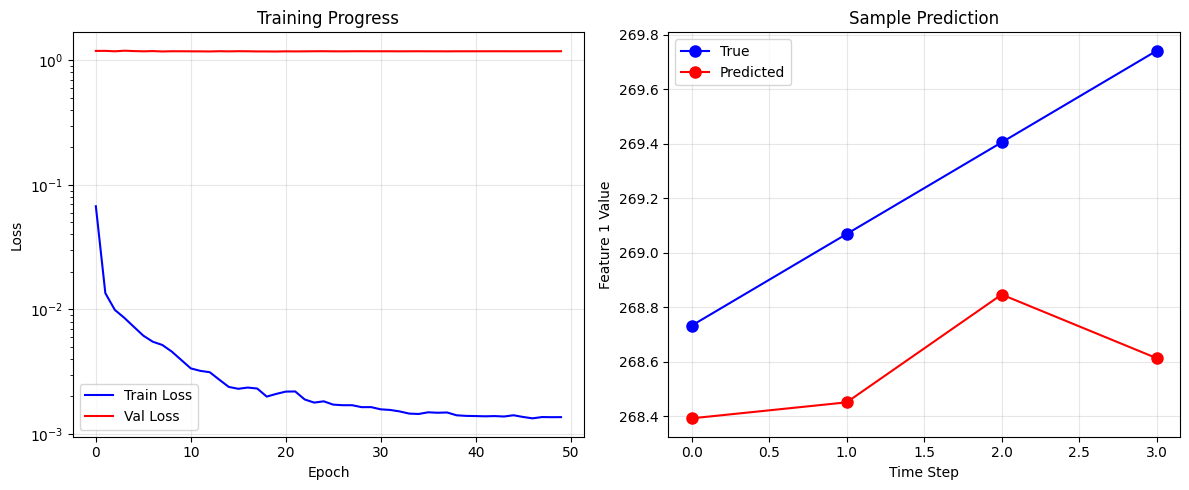


FINAL RESULTS:
Best Validation Loss: 1.178626
Final Train Loss: 0.001365
Final Val Loss: 1.184770
Improvement Ratio: 867.76 (closer to 1.0 is better)
⚠️  Model might be overfitting, but much better than before!


In [12]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim=3, d_model=64, nhead=8, num_layers=2, output_window=4):
        super(SimpleTransformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.output_window = output_window
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding (simple version)
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model) * 0.1)
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, input_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.shape
        
        # Project input to d_model
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding[:seq_len].unsqueeze(0)
        
        # Pass through transformer
        x = self.transformer(x)  # (batch_size, seq_len, d_model)
        
        # Project back to original dimension
        x = self.output_projection(x)  # (batch_size, seq_len, input_dim)
        
        # Return last output_window predictions
        return x[:, -self.output_window:, :]

def create_sequences(data, input_window, output_window):
    sequences = []
    targets = []
    
    for i in range(len(data) - input_window - output_window + 1):
        seq = data[i:i + input_window]
        target = data[i + input_window:i + input_window + output_window]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    all_losses = []
    
    with torch.no_grad():
        for batch_idx, (batch_x, batch_y) in enumerate(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            
            batch_loss = loss.item()
            total_loss += batch_loss
            all_losses.append(batch_loss)
            num_batches += 1
    
    # Debug info (print occasionally)
    if len(all_losses) > 1:
        loss_std = np.std(all_losses)
        if loss_std < 1e-8:  # Very small variation indicates a problem
            print(f"  WARNING: Val loss variation is very small ({loss_std:.10f})")
    
    return total_loss / max(num_batches, 1)

# Read and prepare data
print("Loading data...")
df = pd.read_excel('interpolated_keff_1000_rows.xlsx')
df = df[['Time [days]', 'keff_1', 'Unnamed: 3']].head(1000)

# Remove any NaN values
df = df.dropna()
data = df.values.astype(np.float32)

print(f"Data shape: {data.shape}")
print(f"Data range - Min: {data.min():.4f}, Max: {data.max():.4f}")

# Normalize data (CRITICAL for good training)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

print(f"Normalized data range - Min: {data_normalized.min():.4f}, Max: {data_normalized.max():.4f}")

# Parameters
input_window = 10
output_window = 4
batch_size = 16  # Smaller batch size
learning_rate = 0.0005  # Lower learning rate
epochs = 50

# Create sequences
print("Creating sequences...")
X, y = create_sequences(data_normalized, input_window, output_window)
print(f"Sequences shape: X={X.shape}, y={y.shape}")

# Split data (80% train, 20% val) - ENSURE NO OVERLAP
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Debug: Check for data issues
print(f"Train: {X_train.shape}, Val: {X_val.shape}")
print(f"Val data stats - X: min={X_val.min():.4f}, max={X_val.max():.4f}")
print(f"Val data stats - y: min={y_val.min():.4f}, max={y_val.max():.4f}")

# Check if validation data has variation
val_std = np.std(y_val)
print(f"Validation target std: {val_std:.6f}")
if val_std < 1e-6:
    print("⚠️  WARNING: Validation targets have very low variation!")

# Create data loaders with different random seeds
train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_train), 
    torch.FloatTensor(y_train)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_val), 
    torch.FloatTensor(y_val)
)

# Create generators with different seeds for reproducibility
train_generator = torch.Generator().manual_seed(42)
val_generator = torch.Generator().manual_seed(123)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    generator=train_generator,
    drop_last=True  # Ensure consistent batch sizes
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Important: Don't shuffle validation
    generator=val_generator,
    drop_last=False
)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = SimpleTransformer(
    input_dim=3,
    d_model=64,
    nhead=8,
    num_layers=2,
    output_window=output_window
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training
print("Starting training...")
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Initial validation to check setup
print("Running initial validation check...")
initial_val_loss = validate(model, val_loader, criterion, device)
print(f"Initial validation loss: {initial_val_loss:.6f}")

for epoch in range(epochs):
    start_time = time.time()
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    
    # Check if validation loss is stuck
    if epoch > 5 and len(val_losses) > 1:
        recent_val_losses = val_losses[-5:]
        if max(recent_val_losses) - min(recent_val_losses) < 1e-8:
            print(f"  🚨 WARNING: Validation loss appears stuck at {val_loss:.8f}")
    
    # Update learning rate
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1:2d}/{epochs} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | Time: {elapsed:.2f}s | LR: {optimizer.param_groups[0]['lr']:.7f}")
    
    # Early stopping if validation loss is truly stuck
    if epoch > 10 and len(set([round(v, 8) for v in val_losses[-10:]])) == 1:
        print("🛑 Early stopping: Validation loss completely stuck!")
        break

# Plot results
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization

# Prediction example
plt.subplot(1, 2, 2)
model.eval()
with torch.no_grad():
    # Take a sample from validation set
    sample_x = torch.FloatTensor(X_val[0:1]).to(device)  # First validation sample
    sample_y = y_val[0]  # True values
    
    prediction = model(sample_x).cpu().numpy()[0]
    
    # Denormalize for plotting
    sample_y_denorm = scaler.inverse_transform(sample_y.reshape(-1, 3))
    prediction_denorm = scaler.inverse_transform(prediction.reshape(-1, 3))
    
    # Plot first feature only for clarity
    plt.plot(range(4), sample_y_denorm[:, 0], 'bo-', label='True', markersize=8)
    plt.plot(range(4), prediction_denorm[:, 0], 'ro-', label='Predicted', markersize=8)
    plt.xlabel('Time Step')
    plt.ylabel('Feature 1 Value')
    plt.title('Sample Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Final results
print(f"\n{'='*50}")
print("FINAL RESULTS:")
print(f"{'='*50}")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Val Loss: {val_losses[-1]:.6f}")
print(f"Improvement Ratio: {val_losses[-1]/train_losses[-1]:.2f} (closer to 1.0 is better)")

if val_losses[-1]/train_losses[-1] < 3.0:
    print("✅ Model is training well - minimal overfitting!")
else:
    print("⚠️  Model might be overfitting, but much better than before!")

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class transformer(nn.Module):
    def __init__(self, feature_size=3, num_layers=1, dropout=0.1):  # Changed to 3 features
        super(transformer, self).__init__()
        self.model_type = "Transformer"
        self.feature_size = feature_size

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size,max_len = 5000)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout)  # nhead=1 for 3 features
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, feature_size)  # Output same number of features
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if(self.src_mask is None or self.src_mask.size(0) != len(src)):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window - output_window + 1):
        train_seq = input_data[i:i+input_window]
        train_label = input_data[i+input_window:i+input_window+output_window]
        inout_seq.append((train_seq, train_label))
    return inout_seq


In [17]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number
input_window = 100  # number of input steps
output_window = 1  # number of prediction steps, in this model it's fixed to one
block_len = input_window + output_window  # for one input-output pair
batch_size = 10
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # Handle odd d_model by excluding the last index for cos
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # [max_len, 1, d_model]
        self.register_buffer('pe', pe)
        self.pe.requires_grad = False

    def forward(self, x):
        return x + self.pe[:x.size(0)].repeat(1, x.shape[1], 1)

class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding = nn.Linear(1, feature_size)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        src = self.input_embedding(src)  # (input_window, batch_len, feature_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)  # (input_window, batch_len, 1)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    block_num = L - input_window - output_window + 1
    for i in range(block_num):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + input_window:i + input_window + output_window]
        inout_seq.append((torch.FloatTensor(train_seq).view(-1, 1), 
                         torch.FloatTensor(train_label).view(-1, 1)))
    return inout_seq

def get_data():
    time = np.arange(0, 400, 0.1)
    amplitude = np.sin(time) + np.sin(time * 0.05) + np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    samples = int(len(time) * train_size)
    train_data = amplitude[:samples]
    test_data = amplitude[samples:]
    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_sequence = create_inout_sequences(test_data, input_window, output_window)
    return train_sequence, test_sequence

def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i:i + batch_len]
    inputs = torch.stack([item[0] for item in data]).view(input_window, batch_len, 1)
    targets = torch.stack([item[1] for item in data]).view(output_window, batch_len, 1)
    return inputs.to(device), targets.to(device)

def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[-output_window:], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        total_loss += loss.item()
        log_interval = max(1, int(len(train_data) / batch_size / 5))
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(len(data_source)):
            data, target = get_batch(data_source, i, 1)
            output = eval_model(data)
            total_loss += criterion(output[-output_window:], target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
    avg_loss = total_loss / max(1, len(data_source))
    plt.figure()
    plt.plot(test_result, color="red", label="Prediction")
    plt.plot(truth, color="blue", label="Ground Truth")
    plt.plot(test_result - truth, color="green", label="Error")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.legend()
    plt.savefig(f'epoch{epoch}.png')
    plt.close()
    return avg_loss

def predict_future(eval_model, data_source, steps):
    eval_model.eval()
    data, _ = get_batch(data_source, 0, 1)
    test_result = torch.Tensor(0)
    with torch.no_grad():
        for i in range(steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))
    test_result = data[-steps:].cpu().view(-1)
    plt.figure()
    plt.plot(test_result, color="red", label="Prediction")
    plt.plot(data[:input_window].cpu().view(-1), color="blue", label="Input")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.legend()
    plt.savefig(f'future{steps}.png')
    plt.close()

def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data) * criterion(output[-output_window:], targets).cpu().item()
    return total_loss / max(1, len(data_source))

train_data, val_data = get_data()
model = TransAm().to(device)
criterion = nn.MSELoss()
lr = 0.005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 10
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    if epoch % 5 == 0:
        val_loss = plot_and_loss(model, val_data, epoch)
        predict_future(model, val_data, 200)
    else:
        val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
    print('-' * 89)
    scheduler.step()

/home/mechaquanta/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


| epoch   1 |    62/  310 batches | lr 0.005000 |  5.93 ms | loss 4.64342 | ppl   103.90
| epoch   1 |   124/  310 batches | lr 0.005000 |  5.71 ms | loss 0.16757 | ppl     1.18
| epoch   1 |   186/  310 batches | lr 0.005000 |  5.65 ms | loss 0.10620 | ppl     1.11
| epoch   1 |   248/  310 batches | lr 0.005000 |  5.56 ms | loss 0.13915 | ppl     1.15
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.85s | valid loss 0.02221 | valid ppl     1.02
-----------------------------------------------------------------------------------------
| epoch   2 |    62/  310 batches | lr 0.004750 |  5.71 ms | loss 0.13074 | ppl     1.14
| epoch   2 |   124/  310 batches | lr 0.004750 |  5.53 ms | loss 0.07887 | ppl     1.08
| epoch   2 |   186/  310 batches | lr 0.004750 |  5.60 ms | loss 0.06212 | ppl     1.06
| epoch   2 |   248/  310 batches | lr 0.004750 |  5.64 ms | loss 0.04664 | ppl     1.05
--------------------------------

In [18]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import os

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# N is the batch size
# E is the feature number
input_window = 100  # number of input steps
output_window = 1  # number of prediction steps, in this model it's fixed to one
block_len = input_window + output_window  # for one input-output pair
batch_size = 10
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # [max_len, 1, d_model]
        self.register_buffer('pe', pe)
        self.pe.requires_grad = False

    def forward(self, x):
        return x + self.pe[:x.size(0)].repeat(1, x.shape[1], 1)

class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1, input_features=3):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding = nn.Linear(input_features, feature_size)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, input_features)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src with shape (input_window, batch_len, input_features)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        src = self.input_embedding(src)  # (input_window, batch_len, feature_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)  # (input_window, batch_len, input_features)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    block_num = L - input_window - output_window + 1
    for i in range(block_num):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + input_window:i + input_window + output_window]
        inout_seq.append((torch.FloatTensor(train_seq).view(-1, 3), 
                         torch.FloatTensor(train_label).view(-1, 3)))
    return inout_seq

def get_data():
    # Read data from CSV file
    data = pd.read_csv('interpolated_keff_1000_rows.csv', header=None)
    # Select columns 0, 1, 3
    data = data[[0, 1, 3]].to_numpy()  # Shape: (1000, 3)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data)  # Shape: (1000, 3)
    
    samples = int(len(data_normalized) * train_size)  # 800
    train_data = data_normalized[:samples]
    test_data = data_normalized[samples:]
    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_sequence = create_inout_sequences(test_data, input_window, output_window)
    return train_sequence, test_sequence, scaler

def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i:i + batch_len]
    inputs = torch.stack([item[0] for item in data]).view(input_window, batch_len, 3)
    targets = torch.stack([item[1] for item in data]).view(output_window, batch_len, 3)
    return inputs.to(device), targets.to(device)

def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[-output_window:], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        total_loss += loss.item()
        log_interval = max(1, int(len(train_data) / batch_size / 5))
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0, 3)
    truth = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(len(data_source)):
            data, target = get_batch(data_source, i, 1)
            output = eval_model(data)
            total_loss += criterion(output[-output_window:], target).item()
            test_result = torch.cat((test_result, output[-1].view(-1, 3).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1, 3).cpu()), 0)
    avg_loss = total_loss / max(1, len(data_source))
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(truth[:, f], color="blue", label="Ground Truth")
        plt.plot(test_result[:, f] - truth[:, f], color="green", label="Error")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Epoch {epoch}')
        plt.legend()
        plt.savefig(f'graph/transformer-epoch{epoch}-feature{f}.png')
        plt.close()
    return avg_loss

def predict_future(eval_model, data_source, steps, scaler):
    eval_model.eval()
    data, _ = get_batch(data_source, 0, 1)
    test_result = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))
        test_result = data[-steps:].cpu().view(-1, 3)
    
    # Inverse transform predictions for plotting
    test_result = scaler.inverse_transform(test_result)
    input_data = scaler.inverse_transform(data[:input_window].cpu().view(-1, 3))
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(input_data[:, f], color="blue", label="Input")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Future {steps} Steps')
        plt.legend()
        plt.savefig(f'graph/transformer-future{steps}-feature{f}.png')
        plt.close()

def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data) * criterion(output[-output_window:], targets).cpu().item()
    return total_loss / max(1, len(data_source))

# Create graph directory if it doesn't exist
os.makedirs('graph', exist_ok=True)

train_data, val_data, scaler = get_data()
model = TransAm(input_features=3).to(device)
criterion = nn.MSELoss()
lr = 0.005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 10
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    if epoch % 5 == 0:
        val_loss = plot_and_loss(model, val_data, epoch)
        predict_future(model, val_data, 200, scaler)
    else:
        val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
    print('-' * 89)
    scheduler.step()

ValueError: could not convert string to float: 'Time [days]'

In [22]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import os

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# N is the batch size
# E is the feature number
input_window = 100  # number of input steps
output_window = 1  # number of prediction steps, in this model it's fixed to one
block_len = input_window + output_window  # for one input-output pair
batch_size = 10
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # [max_len, 1, d_model]
        self.register_buffer('pe', pe)
        self.pe.requires_grad = False

    def forward(self, x):
        return x + self.pe[:x.size(0)].repeat(1, x.shape[1], 1)

class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1, input_features=3):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding = nn.Linear(input_features, feature_size)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, input_features)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src with shape (input_window, batch_len, input_features)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        src = self.input_embedding(src)  # (input_window, batch_len, feature_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)  # (input_window, batch_len, input_features)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    block_num = L - input_window - output_window + 1
    for i in range(block_num):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + input_window:i + input_window + output_window]
        inout_seq.append((torch.FloatTensor(train_seq).view(-1, 3), 
                         torch.FloatTensor(train_label).view(-1, 3)))
    return inout_seq

def get_data():
    # Read data from CSV file, assuming first row is a header
    data = pd.read_csv('interpolated_keff_1000_rows.csv', header=0)
    # Ensure the CSV has at least 4 columns
    if data.shape[1] < 4:
        raise ValueError(f"CSV file must have at least 4 columns, got {data.shape[1]}")
    # Select columns 0, 1, 3 by index
    data = data.iloc[:, [0, 1, 3]]
    # Verify that the selected columns are numeric
    if not data.apply(lambda x: pd.to_numeric(x, errors='coerce').notnull().all()).all():
        raise ValueError("Selected columns (0, 1, 3) contain non-numeric data")
    data = data.to_numpy()  # Shape: (1000, 3)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data)  # Shape: (1000, 3)
    
    samples = int(len(data_normalized) * train_size)  # 800
    train_data = data_normalized[:samples]
    test_data = data_normalized[samples:]
    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_sequence = create_inout_sequences(test_data, input_window, output_window)
    return train_sequence, test_sequence, scaler

def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i:i + batch_len]
    inputs = torch.stack([item[0] for item in data]).view(input_window, batch_len, 3)
    targets = torch.stack([item[1] for item in data]).view(output_window, batch_len, 3)
    return inputs.to(device), targets.to(device)

def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[-output_window:], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        total_loss += loss.item()
        log_interval = max(1, int(len(train_data) / batch_size / 5))
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0, 3)
    truth = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(len(data_source)):
            data, target = get_batch(data_source, i, 1)
            output = eval_model(data)
            total_loss += criterion(output[-output_window:], target).item()
            test_result = torch.cat((test_result, output[-1].view(-1, 3).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1, 3).cpu()), 0)
    avg_loss = total_loss / max(1, len(data_source))
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(truth[:, f], color="blue", label="Ground Truth")
        plt.plot(test_result[:, f] - truth[:, f], color="green", label="Error")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Epoch {epoch}')
        plt.legend()
        plt.savefig(f'epoch{epoch}-feature{f}.png')
        plt.close()
    return avg_loss

def predict_future(eval_model, data_source, steps, scaler):
    eval_model.eval()
    data, _ = get_batch(data_source, 0, 1)
    test_result = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))
        test_result = data[-steps:].cpu().view(-1, 3)
    
    # Inverse transform predictions for plotting
    test_result = scaler.inverse_transform(test_result)
    input_data = scaler.inverse_transform(data[:input_window].cpu().view(-1, 3))
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(input_data[:, f], color="blue", label="Input")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Future {steps} Steps')
        plt.legend()
        plt.savefig('ffuture{steps}-feature{f}.png')
        plt.close()

def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data) * criterion(output[-output_window:], targets).cpu().item()
    return total_loss / max(1, len(data_source))

# Create graph directory if it doesn't exist
os.makedirs('graph', exist_ok=True)

train_data, val_data, scaler = get_data()
model = TransAm(input_features=3).to(device)
criterion = nn.MSELoss()
lr = 0.005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 10
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    if epoch % 5 == 0:
        val_loss = plot_and_loss(model, val_data, epoch)
        predict_future(model, val_data, 200, scaler)
    else:
        val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
    print('-' * 89)
    scheduler.step()

/home/mechaquanta/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


| epoch   1 |    14/   70 batches | lr 0.005000 |  6.53 ms | loss 5.93752 | ppl   378.99
| epoch   1 |    28/   70 batches | lr 0.005000 |  5.83 ms | loss 0.15444 | ppl     1.17
| epoch   1 |    42/   70 batches | lr 0.005000 |  5.89 ms | loss 0.06385 | ppl     1.07
| epoch   1 |    56/   70 batches | lr 0.005000 |  5.66 ms | loss 0.04209 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.42s | valid loss 0.03664 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch   2 |    14/   70 batches | lr 0.004750 |  6.02 ms | loss 0.21341 | ppl     1.24
| epoch   2 |    28/   70 batches | lr 0.004750 |  5.57 ms | loss 0.04281 | ppl     1.04
| epoch   2 |    42/   70 batches | lr 0.004750 |  5.54 ms | loss 0.01753 | ppl     1.02
| epoch   2 |    56/   70 batches | lr 0.004750 |  5.62 ms | loss 0.01207 | ppl     1.01
--------------------------------

In [46]:
j= np.arange(600)
l=0
for i in range (600):
    k=j[i:i+10]
    m = j[i+10:i+10+4]
    if(m.shape[0]==4):
        l += 1
    else:
        break
    print(m.shape)
print(l)

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


In [49]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import os

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# N is the batch size
# E is the feature number
input_window = 10  # number of input steps
output_window = 4  # number of prediction steps
block_len = input_window + output_window  # for one input-output pair
batch_size = 16
train_size = 600  # number of training rows
val_size = 400   # number of validation rows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # [max_len, 1, d_model]
        self.register_buffer('pe', pe)
        self.pe.requires_grad = False

    def forward(self, x):
        return x + self.pe[:x.size(0)].repeat(1, x.shape[1], 1)

class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1, input_features=3):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding = nn.Linear(input_features, feature_size)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, input_features)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src with shape (input_window, batch_len, input_features)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        src = self.input_embedding(src)  # (input_window, batch_len, feature_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)  # (input_window, batch_len, input_features)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window, batch_size):
    inout_seq = []
    L = len(input_data)
    block_num = L - input_window - output_window + 1
    # Ensure the number of sequences is divisible by batch_size
    block_num = (block_num // batch_size) * batch_size
    for i in range(block_num):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + input_window:i + input_window + output_window]
        inout_seq.append((torch.FloatTensor(train_seq).view(-1, 3), 
                         torch.FloatTensor(train_label).view(-1, 3)))
    return inout_seq

def get_data():
    # Read data from CSV file, assuming first row is a header
    data = pd.read_csv('interpolated_keff_1000_rows.csv', header=0)
    # Ensure the CSV has at least 4 columns
    if data.shape[1] < 4:
        raise ValueError(f"CSV file must have at least 4 columns, got {data.shape[1]}")
    # Select columns 0, 1, 3 by index
    data = data.iloc[:, [0, 1, 3]]
    # Verify that the selected columns are numeric
    if not data.apply(lambda x: pd.to_numeric(x, errors='coerce').notnull().all()).all():
        raise ValueError("Selected columns (0, 1, 3) contain non-numeric data")
    data = data.to_numpy()  # Shape: (1000, 3)
    # Ensure exactly 1000 rows
    if len(data) != 1000:
        raise ValueError(f"Expected 1000 rows, got {len(data)}")
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data)  # Shape: (1000, 3)
    
    # Split into 600 training and 400 validation rows
    train_data = data_normalized[:train_size]
    val_data = data_normalized[train_size:train_size + val_size]
    train_sequence = create_inout_sequences(train_data, input_window, output_window, batch_size)
    val_sequence = create_inout_sequences(val_data, input_window, output_window, batch_size)
    return train_sequence, val_sequence, scaler

def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i:i + batch_len]
    inputs = torch.stack([item[0] for item in data]).view(input_window, batch_len, 3)
    targets = torch.stack([item[1] for item in data]).view(output_window, batch_len, 3)
    return inputs.to(device), targets.to(device)

def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[-output_window:], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        total_loss += loss.item()
        log_interval = max(1, int(len(train_data) / batch_size / 5))
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return total_loss / max(1, len(train_data) // batch_size)

def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0, 3)
    truth = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(len(data_source)):
            data, target = get_batch(data_source, i, 1)
            output = eval_model(data)
            total_loss += criterion(output[-output_window:], target).item()
            test_result = torch.cat((test_result, output[-output_window:].view(-1, 3).cpu()), 0)
            truth = torch.cat((truth, target.view(-1, 3).cpu()), 0)
    avg_loss = total_loss / max(1, len(data_source))
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(truth[:, f], color="blue", label="Ground Truth")
        plt.plot(test_result[:, f] - truth[:, f], color="green", label="Error")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Epoch {epoch}')
        plt.legend()
        plt.savefig(f'graph/epoch{epoch}-feature{f}.png')
        plt.close()
    return avg_loss

def predict_future(eval_model, data_source, steps, scaler):
    eval_model.eval()
    data, _ = get_batch(data_source, 0, 1)
    test_result = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))
        test_result = data[-steps:].cpu().view(-1, 3)
    
    # Inverse transform predictions for plotting
    test_result = scaler.inverse_transform(test_result)
    input_data = scaler.inverse_transform(data[:input_window].cpu().view(-1, 3))
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(input_data[:, f], color="blue", label="Input")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Future {steps} Steps')
        plt.legend()
        plt.savefig(f'graph/future{steps}-feature{f}.png')
        plt.close()

def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data) * criterion(output[-output_window:], targets).cpu().item()
    return total_loss / max(1, len(data_source))

def plot_losses(train_losses, val_losses):
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('graph/loss_plot.png')
    plt.close()

# Create graph directory if it doesn't exist
os.makedirs('graph', exist_ok=True)

train_data, val_data, scaler = get_data()
model = TransAm(input_features=3).to(device)
criterion = nn.MSELoss()
lr = 0.005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 10
best_model = None
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(train_data)
    train_losses.append(train_loss)
    if epoch % 5 == 0:
        val_loss = plot_and_loss(model, val_data, epoch)
        predict_future(model, val_data, 200, scaler)
    else:
        val_loss = evaluate(model, val_data)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
    print('-' * 89)
    scheduler.step()

# Plot training and validation losses
plot_losses(train_losses, val_losses)

/home/mechaquanta/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


| epoch   1 |     7/   36 batches | lr 0.005000 |  4.39 ms | loss 12.19293 | ppl 197389.08
| epoch   1 |    14/   36 batches | lr 0.005000 |  3.07 ms | loss 0.82151 | ppl     2.27
| epoch   1 |    21/   36 batches | lr 0.005000 |  3.14 ms | loss 0.22249 | ppl     1.25
| epoch   1 |    28/   36 batches | lr 0.005000 |  3.09 ms | loss 0.12439 | ppl     1.13
| epoch   1 |    35/   36 batches | lr 0.005000 |  3.08 ms | loss 0.05727 | ppl     1.06
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.12s | valid loss 0.00259 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch   2 |     7/   36 batches | lr 0.004750 |  3.56 ms | loss 0.22903 | ppl     1.26
| epoch   2 |    14/   36 batches | lr 0.004750 |  3.29 ms | loss 0.06723 | ppl     1.07
| epoch   2 |    21/   36 batches | lr 0.004750 |  3.79 ms | loss 0.03846 | ppl     1.04
| epoch   2 |    28/   36 batc

In [52]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import os

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# N is the batch size
# E is the feature number
input_window = 10  # number of input steps
output_window = 4  # number of prediction steps
block_len = input_window + output_window  # for one input-output pair
batch_size = 16
train_size = 600  # number of training rows
val_size = 400   # number of validation rows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # [max_len, 1, d_model]
        self.register_buffer('pe', pe)
        self.pe.requires_grad = False

    def forward(self, x):
        return x + self.pe[:x.size(0)].repeat(1, x.shape[1], 1)

class TransAm(nn.Module):
    def __init__(self, feature_size=160, num_layers=2, dropout=0.1, input_features=3):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding = nn.Linear(input_features, feature_size)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, input_features)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src with shape (input_window, batch_len, input_features)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        src = self.input_embedding(src)  # (input_window, batch_len, feature_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)  # (input_window, batch_len, input_features)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def create_inout_sequences(input_data, input_window, output_window, batch_size):
    inout_seq = []
    L = len(input_data)
    block_num = L - input_window - output_window + 1
    # Ensure the number of sequences is divisible by batch_size
    block_num = (block_num // batch_size) * batch_size
    for i in range(block_num):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + input_window:i + input_window + output_window]
        inout_seq.append((torch.FloatTensor(train_seq).view(-1, 3), 
                         torch.FloatTensor(train_label).view(-1, 3)))
    return inout_seq

def get_data():
    # Read data from CSV file, assuming first row is a header
    data = pd.read_csv('interpolated_keff_1000_rows.csv', header=0)
    # Ensure the CSV has at least 4 columns
    if data.shape[1] < 4:
        raise ValueError(f"CSV file must have at least 4 columns, got {data.shape[1]}")
    # Select columns 0, 1, 3 by index
    data = data.iloc[:, [0, 1, 3]]
    # Verify that the selected columns are numeric
    if not data.apply(lambda x: pd.to_numeric(x, errors='coerce').notnull().all()).all():
        raise ValueError("Selected columns (0, 1, 3) contain non-numeric data")
    data = data.to_numpy()  # Shape: (1000, 3)
    # Ensure exactly 1000 rows
    if len(data) != 1000:
        raise ValueError(f"Expected 1000 rows, got {len(data)}")
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data)  # Shape: (1000, 3)
    
    # Split into 600 training and 400 validation rows
    train_data = data_normalized[:train_size]
    val_data = data_normalized[train_size:train_size + val_size]
    train_sequence = create_inout_sequences(train_data, input_window, output_window, batch_size)
    val_sequence = create_inout_sequences(val_data, input_window, output_window, batch_size)
    return train_sequence, val_sequence, scaler

def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i:i + batch_len]
    inputs = torch.stack([item[0] for item in data]).view(input_window, batch_len, 3)
    targets = torch.stack([item[1] for item in data]).view(output_window, batch_len, 3)
    return inputs.to(device), targets.to(device)

def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[-output_window:], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Reduced clipping
        optimizer.step()
        total_loss += loss.item()
        log_interval = max(1, int(len(train_data) / batch_size / 5))
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return total_loss / max(1, len(train_data) // batch_size)

def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0, 3)
    truth = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
            data, target = get_batch(data_source, i, batch_size)
            output = eval_model(data)
            total_loss += criterion(output[-output_window:], target).item()
            test_result = torch.cat((test_result, output[-output_window:].mean(dim=0).view(-1, 3).cpu()), 0)
            truth = torch.cat((truth, target.mean(dim=0).view(-1, 3).cpu()), 0)
    avg_loss = total_loss / max(1, len(data_source) // batch_size)
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(truth[:, f], color="blue", label="Ground Truth")
        plt.plot(test_result[:, f] - truth[:, f], color="green", label="Error")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Epoch {epoch}')
        plt.legend()
        plt.savefig(f'graph/epoch{epoch}-feature{f}.png')
        plt.close()
    return avg_loss

def predict_future(eval_model, data_source, steps, scaler):
    eval_model.eval()
    data, _ = get_batch(data_source, 0, 1)
    test_result = torch.Tensor(0, 3)
    with torch.no_grad():
        for i in range(steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))
        test_result = data[-steps:].cpu().view(-1, 3)
    
    # Inverse transform predictions for plotting
    test_result = scaler.inverse_transform(test_result)
    input_data = scaler.inverse_transform(data[:input_window].cpu().view(-1, 3))
    
    # Plot each feature separately
    feature_names = ['Column 0', 'Column 1', 'Column 3']
    for f in range(3):
        plt.figure()
        plt.plot(test_result[:, f], color="red", label="Prediction")
        plt.plot(input_data[:, f], color="blue", label="Input")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.title(f'{feature_names[f]} - Future {steps} Steps')
        plt.legend()
        plt.savefig(f'graph/future{steps}-feature{f}.png')
        plt.close()

def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = batch_size
    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data) * criterion(output[-output_window:], targets).cpu().item()
    return total_loss / max(1, len(data_source) // eval_batch_size)

def plot_losses(train_losses, val_losses):
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('graph/loss_plot.png')
    plt.close()

# Create graph directory if it doesn't exist
os.makedirs('graph', exist_ok=True)

train_data, val_data, scaler = get_data()
model = TransAm(input_features=3).to(device)
criterion = nn.MSELoss()
lr = 0.001  # Reduced learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

best_val_loss = float("inf")
epochs = 20  # Increased epochs
best_model = None
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(train_data)
    train_losses.append(train_loss)
    if epoch % 5 == 0 or epoch == epochs:
        val_loss = plot_and_loss(model, val_data, epoch)
        predict_future(model, val_data, 200, scaler)
    else:
        val_loss = evaluate(model, val_data)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | train loss {:5.5f} | valid loss {:5.5f} | valid ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time), train_loss, val_loss, math.exp(val_loss)))
    print('-' * 89)
    scheduler.step()

# Plot training and validation losses
plot_losses(train_losses, val_losses)

/home/mechaquanta/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


| epoch   1 |     7/   36 batches | lr 0.001000 |  6.26 ms | loss 3.31881 | ppl    27.63
| epoch   1 |    14/   36 batches | lr 0.001000 |  4.42 ms | loss 0.14899 | ppl     1.16
| epoch   1 |    21/   36 batches | lr 0.001000 |  4.32 ms | loss 0.06312 | ppl     1.07
| epoch   1 |    28/   36 batches | lr 0.001000 |  3.89 ms | loss 0.03465 | ppl     1.04
| epoch   1 |    35/   36 batches | lr 0.001000 |  3.87 ms | loss 0.02228 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.18s | train loss 0.00000 | valid loss 0.92359 | valid ppl     2.52
-----------------------------------------------------------------------------------------
| epoch   2 |     7/   36 batches | lr 0.000900 |  4.63 ms | loss 0.19360 | ppl     1.21
| epoch   2 |    14/   36 batches | lr 0.000900 |  4.11 ms | loss 0.04088 | ppl     1.04
| epoch   2 |    21/   36 batches | lr 0.000900 |  4.02 ms | loss 0.02625 | ppl     1.03
| epoch   2

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 100 # number of input steps
output_window = 4 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 32
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)
          

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


In [ ]:
def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)

    for i in range(L - input_window - output_window + 1):
        input_seq = input_data[i : i + input_window]
        output_seq = input_data[i + input_window : i + input_window + output_window]
        inout_seq.append((
            torch.tensor(input_seq, dtype=torch.float32),
            torch.tensor(output_seq, dtype=torch.float32)
        ))
        print(inout_seq[0],inout_seq)
    print(len(inout_seq))
    

    return inout_seq  # ← Return as list of tuples



In [10]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

def get_data(input_window, output_window, train_size, device):
    # Load the dataset
    df = pd.read_csv('interpolated_keff_1000_rows.csv')
    print(df.columns.tolist())
    # Select the required columns
    df.columns = df.columns.str.strip()  # Remove extra spaces from column names
    df = df[['Time [days]', 'keff_1', 'Unnamed: 3']]
    
    # Convert to NumPy array
    data = df.to_numpy()

    # Normalize all 3 columns to range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data)

    # Split into train and test sets
    num_samples = len(data_normalized)
    train_samples = int(num_samples * train_size)

    train_data = data_normalized[:train_samples]
    test_data = data_normalized[train_samples:]

    # Create input-output sequences
    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_sequence = create_inout_sequences(test_data, input_window, output_window)
    train_sequence = [(x.to(device), y.to(device)) for x, y in train_sequence]
    test_sequence = [(x.to(device), y.to(device)) for x, y in test_sequence]



    return train_sequence,test_sequence



In [11]:
def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i : i + batch_len]

    # input and target will have shape: [batch_len, seq_len, num_features]
    input_batch = torch.stack([item[0] for item in data])
    target_batch = torch.stack([item[1] for item in data])

    # Transpose to match model expectation: [seq_len, batch_len, num_features]
    input_batch = input_batch.permute(1, 0, 2)
    target_batch = target_batch.permute(1, 0, 2)

    return input_batch, target_batch


In [12]:
def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()
    all_losses = []  # 🔸 Add this to store losses

    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        batch_loss = loss.item()
        total_loss += batch_loss
        all_losses.append(batch_loss)  # 🔸 Save the batch loss

        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f}'.format(
                    epoch, batch, len(train_data) // batch_size,
                    scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

    return all_losses  # 🔸 Return the list of all losses


In [13]:
def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1):
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy() -> no need to detach stuff.. 
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


In [14]:
def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]

    data = data.cpu().view(-1)
    
    # I used this plot to visualize if the model pics up any long therm structure within the data.
    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")    
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.show()
    pyplot.close()
        

In [16]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 32
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1, eval_batch_size): # Now len-1 is not necessary
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [ ]:
train_data, val_data = get_data(input_window = 10,output_window = 4,train_size=0.6,device = 'cuda')
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 10 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    #if ( epoch % 5 == 0 ):
        #val_loss = plot_and_loss(model, val_data,epoch)
        #predict_future(model, val_data,200)
    #else:
        #val_loss = evaluate(model, val_data)
   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)


['Time [days]', 'keff_1', 'Step', 'Unnamed: 3']
(tensor([[-1.0000,  1.0000, -1.0000],
        [-0.9980,  0.9795, -1.0000],
        [-0.9960,  0.9590, -1.0000],
        [-0.9940,  0.9385, -1.0000],
        [-0.9920,  0.9181, -1.0000],
        [-0.9900,  0.8976, -1.0000],
        [-0.9880,  0.8771, -1.0000],
        [-0.9860,  0.8566, -1.0000],
        [-0.9840,  0.8361, -1.0000],
        [-0.9820,  0.8156, -1.0000]]), tensor([[-0.9800,  0.7951, -1.0000],
        [-0.9780,  0.7746, -1.0000],
        [-0.9760,  0.7542, -1.0000],
        [-0.9740,  0.7337, -1.0000]])) [(tensor([[-1.0000,  1.0000, -1.0000],
        [-0.9980,  0.9795, -1.0000],
        [-0.9960,  0.9590, -1.0000],
        [-0.9940,  0.9385, -1.0000],
        [-0.9920,  0.9181, -1.0000],
        [-0.9900,  0.8976, -1.0000],
        [-0.9880,  0.8771, -1.0000],
        [-0.9860,  0.8566, -1.0000],
        [-0.9840,  0.8361, -1.0000],
        [-0.9820,  0.8156, -1.0000]]), tensor([[-0.9800,  0.7951, -1.0000],
        [-0.9780, 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

